# Evaluasi Performa Metode Similarity

Notebook ini melakukan evaluasi performa berbagai metode similarity menggunakan metrik:
- **Precision**: TP / (TP + FP) - Proporsi dokumen relevan dari yang diambil
- **Recall**: TP / (TP + FN) - Proporsi dokumen relevan yang berhasil diambil  
- **F1-Score**: 2 * (Precision * Recall) / (Precision + Recall) - Harmonic mean
- **Accuracy**: (TP + TN) / (TP + TN + FP + FN) - Proporsi prediksi yang benar

Data gold standard diambil dari kolom `dokumen_yang_mirip` dalam file query.csv

In [1]:
import pandas as pd
import numpy as np
import re
from typing import List, Dict, Tuple, Set
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## Fungsi-fungsi Evaluasi

## Penjelasan Metrik Accuracy

**Accuracy** dalam konteks Information Retrieval dihitung sebagai:
```
Accuracy = (TP + TN) / (TP + TN + FP + FN)
```

Dimana:
- **TP (True Positive)**: Dokumen yang diprediksi relevan dan memang relevan
- **TN (True Negative)**: Dokumen yang tidak diprediksi relevan dan memang tidak relevan  
- **FP (False Positive)**: Dokumen yang diprediksi relevan tapi sebenarnya tidak relevan
- **FN (False Negative)**: Dokumen yang relevan tapi tidak diprediksi

**Catatan Penting**: 
- Untuk menghitung TN, kita memerlukan estimasi total dokumen dalam corpus
- Dalam implementasi ini, kita menggunakan asumsi bahwa corpus memiliki jumlah dokumen tertentu
- Sesuaikan parameter `total_docs` sesuai dengan ukuran corpus yang sebenarnya

In [2]:
def parse_gold_standard(gold_standard_str: str) -> Set[int]:
    """
    Parse string gold standard menjadi set of document IDs
    
    Args:
        gold_standard_str: String berisi dokumen relevan (format: "41, 31" atau "44, 47, 61, 87")
        
    Returns:
        Set of document IDs
    """
    if pd.isna(gold_standard_str) or gold_standard_str == "":
        return set()
    
    # Bersihkan string dan split berdasarkan koma
    doc_ids = []
    for doc_id in str(gold_standard_str).split(','):
        doc_id = doc_id.strip()
        if doc_id and doc_id.isdigit():
            doc_ids.append(int(doc_id))
    
    return set(doc_ids)

def parse_prediction_results(prediction_str: str) -> Set[int]:
    """
    Parse string hasil prediksi menjadi set of document IDs
    
    Args:
        prediction_str: String berisi hasil prediksi (format: "(41), (31), (52)")
        
    Returns:
        Set of document IDs
    """
    if pd.isna(prediction_str) or prediction_str == "":
        return set()
    
    # Extract numbers dalam kurung
    doc_ids = []
    matches = re.findall(r'\((\d+)\)', str(prediction_str))
    for match in matches:
        doc_ids.append(int(match))
    
    return set(doc_ids)

def calculate_metrics(predicted: Set[int], actual: Set[int], total_docs: int = 100) -> Dict[str, float]:
    """
    Hitung precision, recall, F1-score, dan accuracy
    
    Args:
        predicted: Set dokumen yang diprediksi relevan
        actual: Set dokumen yang benar-benar relevan (gold standard)
        total_docs: Total dokumen dalam corpus (untuk menghitung TN)
        
    Returns:
        Dictionary berisi precision, recall, F1-score, accuracy
    """
    if len(actual) == 0:
        # Jika tidak ada dokumen relevan di gold standard
        if len(predicted) == 0:
            return {'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'accuracy': 1.0, 'tp': 0, 'fp': 0, 'fn': 0, 'tn': total_docs}
        else:
            fp = len(predicted)
            tn = total_docs - fp
            return {'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'accuracy': tn/(tn+fp), 'tp': 0, 'fp': fp, 'fn': 0, 'tn': tn}
    
    if len(predicted) == 0:
        # Jika tidak ada prediksi
        fn = len(actual)
        tn = total_docs - fn
        return {'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'accuracy': tn/(tn+fn), 'tp': 0, 'fp': 0, 'fn': fn, 'tn': tn}
    
    # Hitung True Positive, False Positive, False Negative, True Negative
    tp = len(predicted.intersection(actual))  # Dokumen yang diprediksi dan benar relevan
    fp = len(predicted - actual)              # Dokumen yang diprediksi relevan tapi tidak
    fn = len(actual - predicted)              # Dokumen relevan yang tidak diprediksi
    tn = total_docs - tp - fp - fn           # Dokumen yang tidak relevan dan tidak diprediksi
    
    # Hitung metrik
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0.0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'accuracy': accuracy,
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'tn': tn
    }

print("Evaluation functions with accuracy defined successfully!")

Evaluation functions with accuracy defined successfully!


## Load Data Hasil Similarity

In [3]:
# Load hasil Rabin-Karp
try:
    rk_df = pd.read_excel('RK_similarity_results.xlsx', sheet_name='Results RK')
    print(f"✓ Berhasil load RK_similarity_results.xlsx")
    print(f"  Shape: {rk_df.shape}")
    print(f"  Columns: {list(rk_df.columns)}")
except Exception as e:
    print(f"✗ Error loading RK_similarity_results.xlsx: {e}")

print()

# Load hasil Cosine Similarity
try:
    cosine_df = pd.read_excel('Cosine_similarity_results.xlsx', sheet_name='Results Cosine')
    print(f"✓ Berhasil load Cosine_similarity_results.xlsx")
    print(f"  Shape: {cosine_df.shape}")
    print(f"  Columns: {list(cosine_df.columns)}")
except Exception as e:
    print(f"✗ Error loading Cosine_similarity_results.xlsx: {e}")

✓ Berhasil load RK_similarity_results.xlsx
  Shape: (10, 4)
  Columns: ['id_kueri', 'rk_porter', 'rk_sastrawi', 'expert']

✓ Berhasil load Cosine_similarity_results.xlsx
  Shape: (10, 4)
  Columns: ['id_kueri', 'cosine_porter', 'cosine_sastrawi', 'expert']


In [4]:
# Preview data
print("=== PREVIEW DATA RABIN-KARP ===")
print(rk_df.head())
print()
print("=== PREVIEW DATA COSINE SIMILARITY ===")
print(cosine_df.head())

=== PREVIEW DATA RABIN-KARP ===
   id_kueri                                          rk_porter  \
0         1                                               (22)   
1         2                  (8), (61), (17), (50), (18), (47)   
2         3  (12), (17), (39), (90), (33), (15), (53), (23)...   
3         4                 (33), (28), (87), (40), (38), (34)   
4         5                                                NaN   

                                         rk_sastrawi          expert  
0                                         (22), (13)          41, 31  
1                        (8), (61), (17), (50), (18)  44, 47, 61, 87  
2  (12), (17), (39), (90), (33), (15), (53), (23)...          21, 23  
3                       (33), (28), (87), (40), (38)           2, 10  
4                                                NaN              71  

=== PREVIEW DATA COSINE SIMILARITY ===
   id_kueri                                      cosine_porter  \
0         1                            

## Evaluasi Setiap Metode

In [5]:
def evaluate_method(results_df: pd.DataFrame, method_column: str, 
                   gold_standard_column: str = 'expert', total_docs: int = 100) -> Dict[str, float]:
    """
    Evaluasi satu metode similarity
    
    Args:
        results_df: DataFrame berisi hasil similarity
        method_column: Nama kolom yang berisi hasil prediksi metode
        gold_standard_column: Nama kolom yang berisi gold standard
        total_docs: Total dokumen dalam corpus (untuk menghitung TN)
        
    Returns:
        Dictionary berisi rata-rata precision, recall, F1-score, accuracy
    """
    all_metrics = []
    detailed_results = []
    
    for idx, row in results_df.iterrows():
        query_id = row['id_kueri']
        predicted = parse_prediction_results(row[method_column])
        actual = parse_gold_standard(row[gold_standard_column])
        
        metrics = calculate_metrics(predicted, actual, total_docs)
        all_metrics.append(metrics)
        
        detailed_results.append({
            'query_id': query_id,
            'predicted_docs': predicted,
            'actual_docs': actual,
            'precision': metrics['precision'],
            'recall': metrics['recall'],
            'f1_score': metrics['f1_score'],
            'accuracy': metrics['accuracy'],
            'tp': metrics['tp'],
            'fp': metrics['fp'],
            'fn': metrics['fn'],
            'tn': metrics['tn']
        })
    
    # Hitung rata-rata metrik
    avg_precision = np.mean([m['precision'] for m in all_metrics])
    avg_recall = np.mean([m['recall'] for m in all_metrics])
    avg_f1 = np.mean([m['f1_score'] for m in all_metrics])
    avg_accuracy = np.mean([m['accuracy'] for m in all_metrics])
    
    return {
        'avg_precision': avg_precision,
        'avg_recall': avg_recall,
        'avg_f1_score': avg_f1,
        'avg_accuracy': avg_accuracy,
        'detailed_results': detailed_results,
        'total_queries': len(results_df)
    }

print("Method evaluation function with accuracy defined!")

Method evaluation function with accuracy defined!


## Evaluasi Semua Metode

In [6]:
print("="*80)
print("EVALUASI PERFORMA METODE SIMILARITY")
print("="*80)

# Evaluasi setiap metode
methods = [
    ('Rabin-Karp + Porter Stemmer', rk_df, 'rk_porter'),
    ('Rabin-Karp + Sastrawi Stemmer', rk_df, 'rk_sastrawi'),
    ('Cosine Similarity + Porter Stemmer', cosine_df, 'cosine_porter'),
    ('Cosine Similarity + Sastrawi Stemmer', cosine_df, 'cosine_sastrawi')
]

evaluation_results = {}

# Estimasi total dokumen dalam corpus (sesuaikan dengan data aktual)
TOTAL_DOCS = 100  # Ganti dengan jumlah dokumen sebenarnya dalam corpus

for method_name, df, column in methods:
    print(f"\nEvaluasi {method_name}...")
    results = evaluate_method(df, column, total_docs=TOTAL_DOCS)
    evaluation_results[method_name] = results
    
    print(f"  Precision: {results['avg_precision']:.4f}")
    print(f"  Recall:    {results['avg_recall']:.4f}")
    print(f"  F1-Score:  {results['avg_f1_score']:.4f}")
    print(f"  Accuracy:  {results['avg_accuracy']:.4f}")
    print(f"  Total Queries: {results['total_queries']}")

print("\n" + "="*80)
print("EVALUASI SELESAI!")
print("="*80)

EVALUASI PERFORMA METODE SIMILARITY

Evaluasi Rabin-Karp + Porter Stemmer...
  Precision: 0.1944
  Recall:    0.2250
  F1-Score:  0.1915
  Accuracy:  0.9580
  Total Queries: 10

Evaluasi Rabin-Karp + Sastrawi Stemmer...
  Precision: 0.2311
  Recall:    0.2000
  F1-Score:  0.1804
  Accuracy:  0.9570
  Total Queries: 10

Evaluasi Cosine Similarity + Porter Stemmer...
  Precision: 0.1592
  Recall:    0.4250
  F1-Score:  0.2085
  Accuracy:  0.9500
  Total Queries: 10

Evaluasi Cosine Similarity + Sastrawi Stemmer...
  Precision: 0.1346
  Recall:    0.4500
  F1-Score:  0.1867
  Accuracy:  0.9410
  Total Queries: 10

EVALUASI SELESAI!


## Tabel Perbandingan Performa

In [7]:
print("="*80)
print("TABEL PERBANDINGAN PERFORMA METODE")
print("="*80)

# Header tabel
print(f"{'Metode':<40} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Accuracy':<12}")
print("-" * 92)

# Data untuk setiap metode
for method_name, results in evaluation_results.items():
    precision = results['avg_precision']
    recall = results['avg_recall']
    f1_score = results['avg_f1_score']
    accuracy = results['avg_accuracy']
    
    print(f"{method_name:<40} {precision:<12.4f} {recall:<12.4f} {f1_score:<12.4f} {accuracy:<12.4f}")

print("-" * 92)

# Cari metode terbaik
best_f1_method = max(evaluation_results.keys(), 
                   key=lambda x: evaluation_results[x]['avg_f1_score'])
best_precision_method = max(evaluation_results.keys(),
                          key=lambda x: evaluation_results[x]['avg_precision'])
best_recall_method = max(evaluation_results.keys(),
                       key=lambda x: evaluation_results[x]['avg_recall'])
best_accuracy_method = max(evaluation_results.keys(),
                         key=lambda x: evaluation_results[x]['avg_accuracy'])

print(f"\nMETODE TERBAIK:")
print(f"  F1-Score terbaik:  {best_f1_method}")
print(f"  Precision terbaik: {best_precision_method}")
print(f"  Recall terbaik:    {best_recall_method}")
print(f"  Accuracy terbaik:  {best_accuracy_method}")
print()

TABEL PERBANDINGAN PERFORMA METODE
Metode                                   Precision    Recall       F1-Score     Accuracy    
--------------------------------------------------------------------------------------------
Rabin-Karp + Porter Stemmer              0.1944       0.2250       0.1915       0.9580      
Rabin-Karp + Sastrawi Stemmer            0.2311       0.2000       0.1804       0.9570      
Cosine Similarity + Porter Stemmer       0.1592       0.4250       0.2085       0.9500      
Cosine Similarity + Sastrawi Stemmer     0.1346       0.4500       0.1867       0.9410      
--------------------------------------------------------------------------------------------

METODE TERBAIK:
  F1-Score terbaik:  Cosine Similarity + Porter Stemmer
  Precision terbaik: Rabin-Karp + Sastrawi Stemmer
  Recall terbaik:    Cosine Similarity + Sastrawi Stemmer
  Accuracy terbaik:  Rabin-Karp + Porter Stemmer



## Analisis Detail per Query

In [8]:
# Tampilkan beberapa contoh hasil evaluasi detail
print("="*80)
print("CONTOH HASIL EVALUASI DETAIL (Query 1-3)")
print("="*80)

for method_name, results in evaluation_results.items():
    print(f"\n--- {method_name} ---")
    for i, detail in enumerate(results['detailed_results'][:3]):  # Hanya 3 query pertama
        print(f"Query {detail['query_id']}:")
        print(f"  Predicted: {sorted(detail['predicted_docs'])}")
        print(f"  Actual:    {sorted(detail['actual_docs'])}")
        print(f"  P: {detail['precision']:.3f}, R: {detail['recall']:.3f}, F1: {detail['f1_score']:.3f}, Acc: {detail['accuracy']:.3f}")
        print(f"  TP: {detail['tp']}, FP: {detail['fp']}, FN: {detail['fn']}, TN: {detail['tn']}")
        print()

CONTOH HASIL EVALUASI DETAIL (Query 1-3)

--- Rabin-Karp + Porter Stemmer ---
Query 1:
  Predicted: [22]
  Actual:    [31, 41]
  P: 0.000, R: 0.000, F1: 0.000, Acc: 0.970
  TP: 0, FP: 1, FN: 2, TN: 97

Query 2:
  Predicted: [8, 17, 18, 47, 50, 61]
  Actual:    [44, 47, 61, 87]
  P: 0.333, R: 0.500, F1: 0.400, Acc: 0.940
  TP: 2, FP: 4, FN: 2, TN: 92

Query 3:
  Predicted: [12, 15, 17, 23, 33, 39, 53, 70, 90]
  Actual:    [21, 23]
  P: 0.111, R: 0.500, F1: 0.182, Acc: 0.910
  TP: 1, FP: 8, FN: 1, TN: 90


--- Rabin-Karp + Sastrawi Stemmer ---
Query 1:
  Predicted: [13, 22]
  Actual:    [31, 41]
  P: 0.000, R: 0.000, F1: 0.000, Acc: 0.960
  TP: 0, FP: 2, FN: 2, TN: 96

Query 2:
  Predicted: [8, 17, 18, 50, 61]
  Actual:    [44, 47, 61, 87]
  P: 0.200, R: 0.250, F1: 0.222, Acc: 0.930
  TP: 1, FP: 4, FN: 3, TN: 92

Query 3:
  Predicted: [12, 15, 17, 23, 33, 39, 53, 70, 90]
  Actual:    [21, 23]
  P: 0.111, R: 0.500, F1: 0.182, Acc: 0.910
  TP: 1, FP: 8, FN: 1, TN: 90


--- Cosine Similarit

## Simpan Hasil Evaluasi ke Excel

In [9]:
# Simpan hasil evaluasi ke Excel
output_file = 'evaluation_results.xlsx'

with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    # Sheet ringkasan
    summary_data = []
    for method_name, results in evaluation_results.items():
        summary_data.append({
            'Metode': method_name,
            'Precision': results['avg_precision'],
            'Recall': results['avg_recall'],
            'F1-Score': results['avg_f1_score'],
            'Accuracy': results['avg_accuracy'],
            'Total_Queries': results['total_queries']
        })
    
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_excel(writer, sheet_name='Summary', index=False)
    
    # Sheet detail untuk setiap metode
    for method_name, results in evaluation_results.items():
        sheet_name = method_name.replace(' ', '_').replace('+', 'and')[:31]  # Excel sheet name limit
        
        detail_data = []
        for detail in results['detailed_results']:
            detail_data.append({
                'Query_ID': detail['query_id'],
                'Predicted_Docs': ', '.join(map(str, sorted(detail['predicted_docs']))),
                'Actual_Docs': ', '.join(map(str, sorted(detail['actual_docs']))),
                'Precision': detail['precision'],
                'Recall': detail['recall'],
                'F1_Score': detail['f1_score'],
                'Accuracy': detail['accuracy'],
                'True_Positive': detail['tp'],
                'False_Positive': detail['fp'],
                'False_Negative': detail['fn'],
                'True_Negative': detail['tn']
            })
        
        detail_df = pd.DataFrame(detail_data)
        detail_df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"✓ Hasil evaluasi detail disimpan ke: {output_file}")
print()
print("File yang dihasilkan:")
print(f"  - {output_file}: Hasil evaluasi detail semua metode")
print()
print("Interpretasi Hasil:")
print("  - Precision tinggi: Metode menghasilkan sedikit false positive")
print("  - Recall tinggi: Metode berhasil menemukan sebagian besar dokumen relevan")
print("  - F1-Score tinggi: Keseimbangan baik antara precision dan recall")
print("  - Accuracy tinggi: Proporsi prediksi yang benar secara keseluruhan")

✓ Hasil evaluasi detail disimpan ke: evaluation_results.xlsx

File yang dihasilkan:
  - evaluation_results.xlsx: Hasil evaluasi detail semua metode

Interpretasi Hasil:
  - Precision tinggi: Metode menghasilkan sedikit false positive
  - Recall tinggi: Metode berhasil menemukan sebagian besar dokumen relevan
  - F1-Score tinggi: Keseimbangan baik antara precision dan recall
  - Accuracy tinggi: Proporsi prediksi yang benar secara keseluruhan


File yang dihasilkan:
  - evaluation_results.xlsx: Hasil evaluasi detail semua metode

Interpretasi Hasil:
  - Precision tinggi: Metode menghasilkan sedikit false positive
  - Recall tinggi: Metode berhasil menemukan sebagian besar dokumen relevan
  - F1-Score tinggi: Keseimbangan baik antara precision dan recall
  - Accuracy tinggi: Proporsi prediksi yang benar secara keseluruhan


## Visualisasi Perbandingan Performa (Opsional)

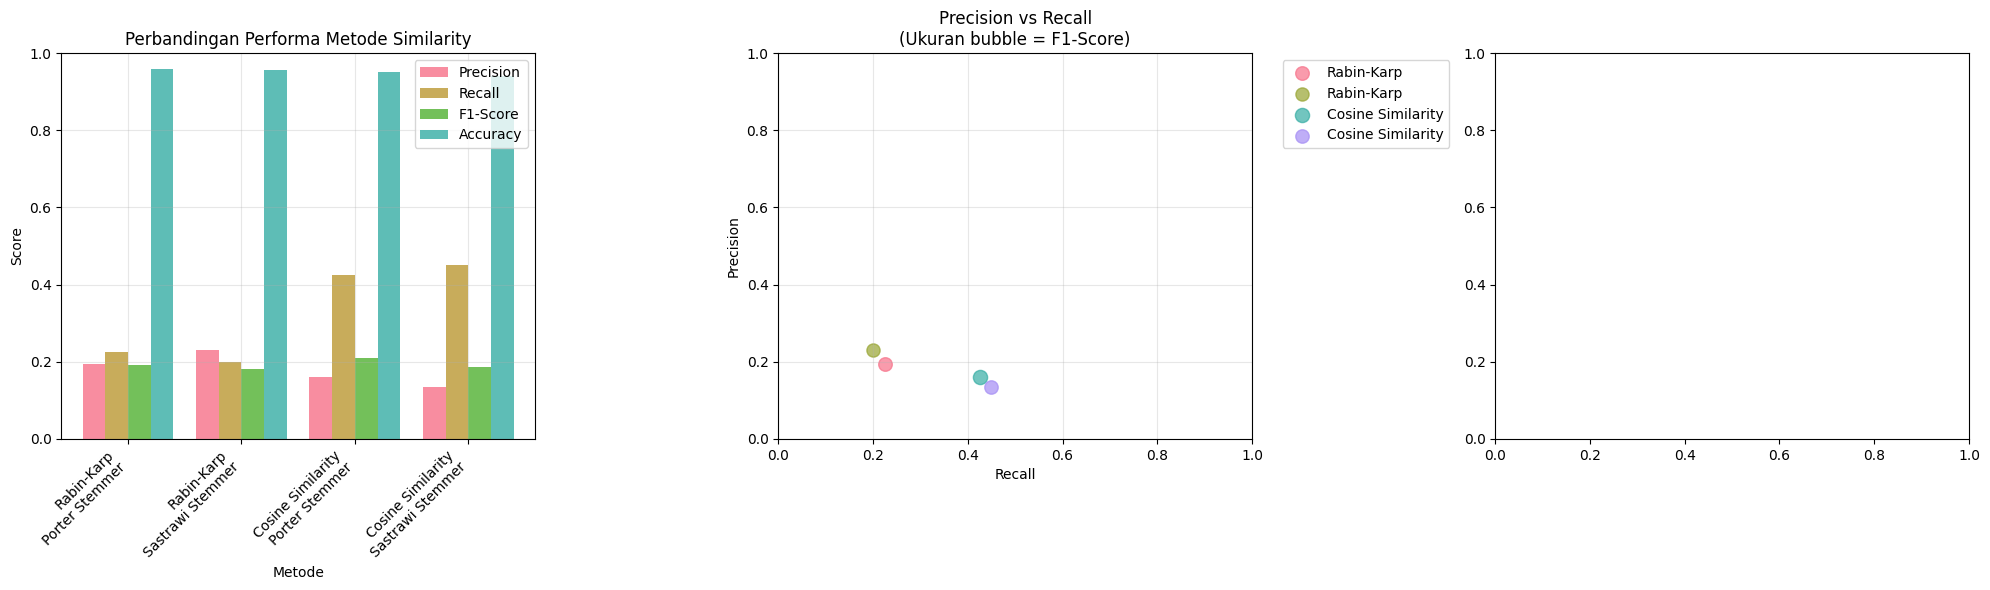

✓ Grafik perbandingan disimpan ke: evaluation_comparison.png


In [ ]:
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Set style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Prepare data for visualization
    methods = list(evaluation_results.keys())
    precision_scores = [evaluation_results[method]['avg_precision'] for method in methods]
    recall_scores = [evaluation_results[method]['avg_recall'] for method in methods]
    f1_scores = [evaluation_results[method]['avg_f1_score'] for method in methods]
    accuracy_scores = [evaluation_results[method]['avg_accuracy'] for method in methods]
    
    # Create subplot (remove F1-Score comparison)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bar plot for all metrics
    x = range(len(methods))
    width = 0.2
    
    ax1.bar([i - 1.5*width for i in x], precision_scores, width, label='Precision', alpha=0.8)
    ax1.bar([i - 0.5*width for i in x], recall_scores, width, label='Recall', alpha=0.8)
    ax1.bar([i + 0.5*width for i in x], f1_scores, width, label='F1-Score', alpha=0.8)
    ax1.bar([i + 1.5*width for i in x], accuracy_scores, width, label='Accuracy', alpha=0.8)
    
    ax1.set_xlabel('Metode')
    ax1.set_ylabel('Score')
    ax1.set_title('Perbandingan Performa Metode Similarity')
    ax1.set_xticks(x)
    ax1.set_xticklabels([method.replace(' + ', '\n') for method in methods], rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)
    
    # Scatter plot: Precision vs Recall
    colors = sns.color_palette("husl", len(methods))
    for i, (method, color) in enumerate(zip(methods, colors)):
        ax2.scatter(recall_scores[i], precision_scores[i], 
                   s=f1_scores[i]*500, alpha=0.7, color=color, 
                   label=method.split(' + ')[0])  # Simplified label
    
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision vs Recall\n(Ukuran bubble = F1-Score)')
    ax2.grid(True, alpha=0.3)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig('evaluation_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Grafik perbandingan disimpan ke: evaluation_comparison.png")
    
except ImportError:
    print("Matplotlib/Seaborn tidak tersedia. Melewati visualisasi.")
except Exception as e:
    print(f"Error dalam membuat visualisasi: {e}")